In [23]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

from tqdm import trange

[Dataset Page](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29)  
[Download Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data)

In [24]:
brest_cancer_columns = [
    'id',
    'Clump Thickness',
    'Uniformity of Cell Size', 
    'Uniformity of Cell Shape', 
    'Marginal Adhesion', 
    'Single Epithelial Cell Size', 
    'Bare Nuclei', 
    'Bland Chromatin', 
    'Normal Nucleoli', 
    'Mitoses',
    'Class'
]
brest_cancer = pd.read_csv('../data/breast-cancer-wisconsin.data')
brest_cancer.columns = brest_cancer_columns
brest_cancer.drop('id', axis=1, inplace=True) # id do not play any role at classification

brest_cancer = brest_cancer[brest_cancer['Bare Nuclei'] != '?']  # TODO take care of it (replace with mean or smth else)

In [25]:
brest_cancer.profile_report(style={'full_width':True})

## Feature Ranking

In [26]:
def make_features_ranking(x, y):
    n_features = x.shape[1]
    # f_classif: ANOVA test (F-value between label/feature for regression tasks)
    k_best_selector = SelectKBest(score_func=f_classif, k=n_features) 
    k_best_selector.fit(x, y)
    scores = k_best_selector.scores_ 
    column_scores = [ 
        {'name': name, 'score': round(score, 2)}  
        for name, score in zip(x.columns, scores)
    ]
    return sorted(column_scores, key=lambda x: x['score'], reverse=True)

In [27]:
x = brest_cancer.drop('Class', axis=1)
y = brest_cancer['Class']
features_ranking = make_features_ranking(x, y)
print('Features Ranking:')
for index, feature in enumerate(features_ranking, 1):
    print(f"{index}. {feature['name']} {feature['score']}")

Features Ranking:
1. Bare Nuclei 1422.73
2. Uniformity of Cell Shape 1414.05
3. Uniformity of Cell Size 1402.65
4. Bland Chromatin 920.35
5. Normal Nucleoli 725.66
6. Clump Thickness 712.48
7. Marginal Adhesion 676.13
8. Single Epithelial Cell Size 620.66
9. Mitoses 148.42


### Experiment

#### Train Test Split

In [28]:
def make_train_test_split(data, target_column):
    x = data.drop(target_column, axis=1)
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    return dict(
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test
    ) 

In [29]:
def select_k_best(data, k):
    x = data['x_train']
    y = data['y_train']
    k_best_selector = SelectKBest(score_func=f_classif, k=k)   
    selected_data = {}
    selected_data['x_train'] = k_best_selector.fit_transform(x, y)
    selected_data['x_test'] = k_best_selector.transform(data['x_test'])
    return {**data, **selected_data}

In [30]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [31]:
CV_REPEAT_NUMBER = 10
CV_FOLDS = 3
SCORE_METHOD = 'accuracy'

grid_search = GridSearchCV(
    param_grid=dict(
        hidden_layer_sizes=[(11,),(15,),(20,)],
        solver=['sgd', 'adam']  # 'adam' -> back propagation without momentum 
    ),
    estimator=MLPClassifier(),
    cv=StratifiedKFold(n_splits=CV_FOLDS)
)

features_scores = []
grid_search_params_scores = {}
learning_data = make_train_test_split(data=brest_cancer, target_column='Class')
features_numbers = learning_data['x_train'].shape[1]

for k in trange(1, features_numbers+1):
    k_features_score = []
    for _ in range(CV_REPEAT_NUMBER):
        selected_data = select_k_best(learning_data, k)
        grid_search.fit(selected_data['x_train'], selected_data['y_train'])
        grid_search_params_scores[k] = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']] 
        k_features_score.append(grid_search.score(selected_data['x_test'],selected_data['y_test']))
    features_scores.append(np.mean(k_features_score))

100%|██████████| 9/9 [03:40<00:00, 24.69s/it]


In [32]:
from pprint import pprint
pprint(grid_search_params_scores)

{1:                                             params  mean_test_score
0   {'hidden_layer_sizes': (11,), 'solver': 'sgd'}         0.929825
1  {'hidden_layer_sizes': (11,), 'solver': 'adam'}         0.728070
2   {'hidden_layer_sizes': (15,), 'solver': 'sgd'}         0.936404
3  {'hidden_layer_sizes': (15,), 'solver': 'adam'}         0.936404
4   {'hidden_layer_sizes': (20,), 'solver': 'sgd'}         0.936404
5  {'hidden_layer_sizes': (20,), 'solver': 'adam'}         0.936404,
 2:                                             params  mean_test_score
0   {'hidden_layer_sizes': (11,), 'solver': 'sgd'}         0.923246
1  {'hidden_layer_sizes': (11,), 'solver': 'adam'}         0.929825
2   {'hidden_layer_sizes': (15,), 'solver': 'sgd'}         0.953947
3  {'hidden_layer_sizes': (15,), 'solver': 'adam'}         0.945175
4   {'hidden_layer_sizes': (20,), 'solver': 'sgd'}         0.958333
5  {'hidden_layer_sizes': (20,), 'solver': 'adam'}         0.953947,
 3:                                   

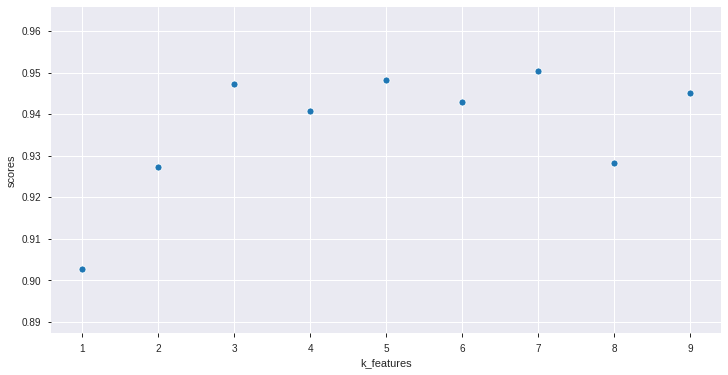

In [33]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=pd.DataFrame(dict(
            k_features=list(range(1, features_numbers+1)), 
            scores=features_scores
    )), 
    x='k_features', 
    y='scores'
)